In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly import tools
from plotly.subplots import make_subplots
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelBinarizer

# Modelling Libraries
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_validate


In [22]:

df = pd.read_csv('adult.csv')
df.head()
df.columns = df.columns.str.lower().str.replace('.', '_')

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.replace('?', np.nan, inplace=True)

# Filling the missing values with mode
ctgrs = ["native_country","occupation","workclass"]


for x in ctgrs:
    df[x].fillna(df[x].mode()[0], inplace=True)
# Dropping fnlwgt
df.drop('fnlwgt', axis=1, inplace=True)

df.reset_index(inplace=True, drop=True)
#Capital gain and capital loss can be combined and transformed into a feature capital difference.

df['Capital_Difference'] = df['capital_gain'] - df['capital_loss']
df.drop(['capital_gain'], axis = 1, inplace = True)
df.drop(['capital_loss'], axis = 1, inplace = True)
# classifying the capital difference into 'Minor' and 'Major'
df['Capital_Difference'] = pd.cut(df['Capital_Difference'], bins = [-5000, 5000, 100000], labels = ['Minor', 'Major'])

df['age'] = pd.cut(df['age'], bins = [0, 25, 50, 100], labels = ['Young', 'Adult', 'Old'])
df.age.value_counts()
# Replacing the values in the race column with 'Other' due to their small count
df['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],' Other', inplace = True)
df.race.value_counts()
# Transforming hours per week into 'Lesser Hours', 'Normal Hours', 'Extra Hours'
df['employment_type'] = pd.cut(df['hours_per_week'], 
                                   bins = [0, 30, 40, 100], 
                                   labels = ['Lesser Hours', 'Normal Hours', 'Extra Hours'])

df.drop('hours_per_week', axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)

df.employment_type.value_counts()
# Replace values in 'native.country' that are not 'United-States' with 'Others'
df['native_country'] = df['native_country'].apply(lambda x: 'Others' if x != 'United-States' else x)

df[['native_country']].value_counts()

# grouping education levels into 'School'
df.drop(['education_num'], axis = 1, inplace = True)
df['education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'],
                             ' School', inplace = True)
df['education'].value_counts()
df.columns

Index(['age', 'workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income',
       'Capital_Difference', 'employment_type'],
      dtype='object')

In [23]:
categorical_columns = ["age","workclass","marital_status","occupation","relationship","race","sex","native_country","employment_type","education","Capital_Difference"]


In [24]:
df=pd.get_dummies(df,drop_first=True,columns=categorical_columns)

In [25]:
df['income']=df['income'].map({'<=50K': 0, '>50K': 1})


In [26]:
X = df.drop('income', axis=1)
y = df['income']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=df['income'])


In [28]:
param_grids = {
    "TREE": {
        'model__max_depth': range(1, 30),
        'model__splitter': ['best', 'random'],
        'model__criterion': ['gini', 'entropy']
    },
    
    "MNB": {
        'model__alpha': [0.1, 1, 10],
        'model__fit_prior': [True, False]
    },
    "GNB": {
        'model__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    "LR": {
        'model__C': [0.1, 1, 10, 100],
        'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'model__max_iter': [100, 200, 300]
    },
    "KNN": {
        'model__n_neighbors': [5, 10, 15, 20],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "XG": {
        'model__n_estimators': [20, 50, 100],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    "RF": {
        'model__n_estimators': [20, 50, 100],
        'model__criterion': ['gini', 'entropy'],
        'model__max_features': ['auto', 'sqrt', 'log2']
    },
    "Voting": {
        'model__voting': ['hard', 'soft'],
        'model__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
    }
}

In [29]:
x_train.head()

,age_Adult,age_Old,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,...,employment_type_Extra Hours,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Prof-school,education_Some-college,Capital_Difference_Major
20092,True,False,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,False
21400,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
374,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
25306,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
13473,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [30]:
x

'workclass'

In [34]:
models = {
    "TREE": DecisionTreeClassifier(),
    "MNB" : MultinomialNB(),
    "GNB": GaussianNB(),
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "XG": XGBClassifier(),
    "RF": RandomForestClassifier(),
    "Voting": VotingClassifier(estimators=[
        ('lr', LogisticRegression()), 
        ('rf', RandomForestClassifier()), 
        ('gnb', GaussianNB())
    ])
}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Score for {model_name}: {grid_search.best_score_}")

Best Parameters for TREE: {'model__criterion': 'gini', 'model__max_depth': 8, 'model__splitter': 'best'}
Best Score for TREE: 0.8432137011790504
Best Parameters for MNB: {'model__alpha': 10, 'model__fit_prior': True}
Best Score for MNB: 0.8236971897127493
Best Parameters for GNB: {'model__var_smoothing': 1e-07}
Best Score for GNB: 0.63548474142929
Best Parameters for LR: {'model__C': 1, 'model__max_iter': 100, 'model__solver': 'liblinear'}
Best Score for LR: 0.851281647607523
Best Parameters for KNN: {'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__weights': 'uniform'}
Best Score for KNN: 0.8294598303959482
Best Parameters for XG: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 50}
Best Score for XG: 0.8512048722323277
Best Parameters for RF: {'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__n_estimators': 100}
Best Score for RF: 0.838949184104796
Best Parameters for Voting: {'model__voting': 'hard', 'model__weights': [2,

In [37]:
models = list()
models.append(("TREE" , DecisionTreeClassifier(criterion='gini', max_depth= 8, splitter='best')))
models.append(("MNB" , MultinomialNB(alpha= 10, fit_prior= True)))
models.append(("GNB" , GaussianNB(var_smoothing= 1e-07)))
models.append(("LR" , LogisticRegression(C=1, max_iter= 100, solver= 'liblinear')))
models.append(("KNN" , KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='uniform')))
models.append(("XG",XGBClassifier(learning_rate= 0.2, max_depth= 5, n_estimators= 50)))
models.append(("RF",RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators= 100)))
models.append(("Voting",VotingClassifier(estimators=[("LR", LogisticRegression()), ("KNN" , KNeighborsClassifier()), ("XG" , XGBClassifier())], voting='hard', weights= [2, 1, 1])))

Best Parameters for TREE: {'model__criterion': 'entropy', 'model__max_depth': 9, 'model__splitter': 'random'}
Best Score for TREE: 0.8430600913820342
Train accuracy: 0.8971
Test accuracy: 0.8210
**************************************************
Classification Report for TREE:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90      4940
           1       0.76      0.52      0.62      1568

    accuracy                           0.84      6508
   macro avg       0.81      0.73      0.76      6508
weighted avg       0.84      0.84      0.83      6508



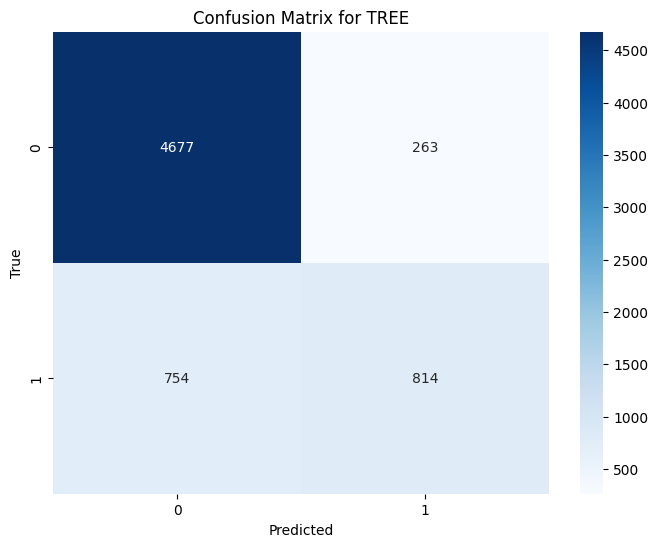

Best Parameters for MNB: {'model__alpha': 10, 'model__fit_prior': True}
Best Score for MNB: 0.8236971897127493
Train accuracy: 0.8246
Test accuracy: 0.8225
**************************************************
Classification Report for MNB:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      4940
           1       0.64      0.65      0.65      1568

    accuracy                           0.83      6508
   macro avg       0.76      0.77      0.77      6508
weighted avg       0.83      0.83      0.83      6508



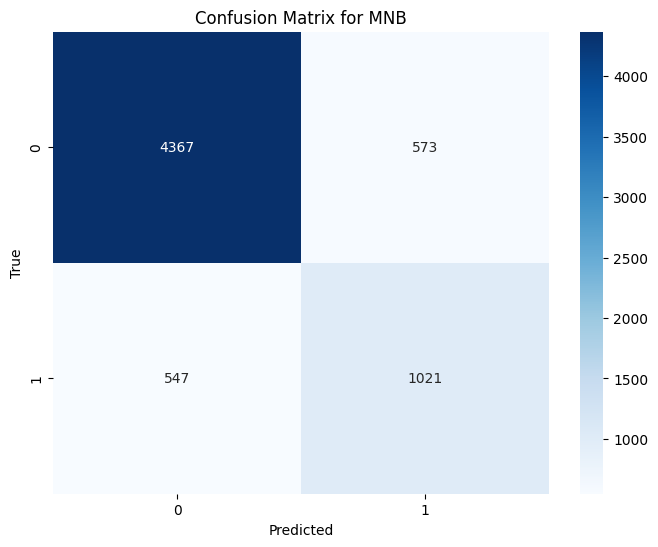

Best Parameters for GNB: {'model__var_smoothing': 1e-07}
Best Score for GNB: 0.63548474142929
Train accuracy: 0.5928
Test accuracy: 0.5927
**************************************************
Classification Report for GNB:
               precision    recall  f1-score   support

           0       0.96      0.57      0.72      4940
           1       0.41      0.93      0.57      1568

    accuracy                           0.66      6508
   macro avg       0.69      0.75      0.64      6508
weighted avg       0.83      0.66      0.68      6508



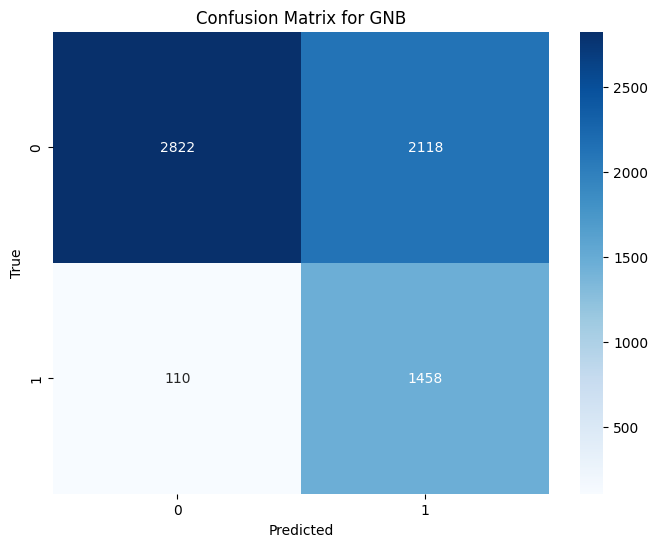

Best Parameters for LR: {'model__C': 1, 'model__max_iter': 100, 'model__solver': 'liblinear'}
Best Score for LR: 0.851281647607523
Train accuracy: 0.8512
Test accuracy: 0.8483
**************************************************
Classification Report for LR:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.58      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



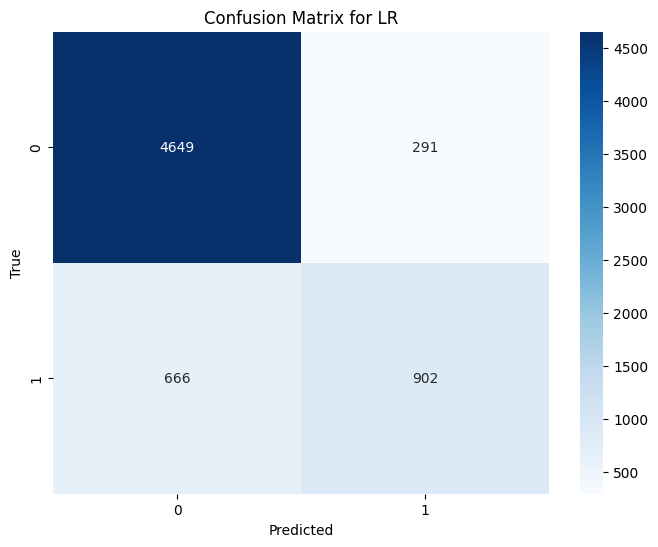

Best Parameters for KNN: {'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__weights': 'uniform'}
Best Score for KNN: 0.8294598303959482
Train accuracy: 0.8414
Test accuracy: 0.8034
**************************************************
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4940
           1       0.68      0.56      0.61      1568

    accuracy                           0.83      6508
   macro avg       0.77      0.74      0.75      6508
weighted avg       0.82      0.83      0.82      6508



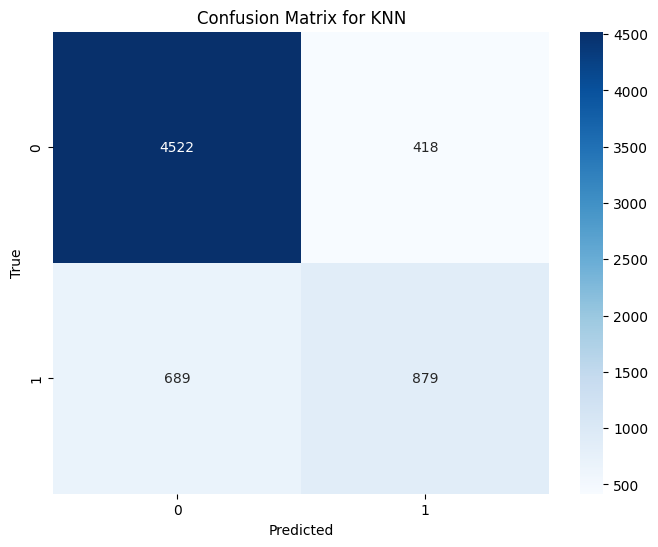

Best Parameters for XG: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 50}
Best Score for XG: 0.8512048722323277
Train accuracy: 0.8703
Test accuracy: 0.8449
**************************************************
Classification Report for XG:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.57      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



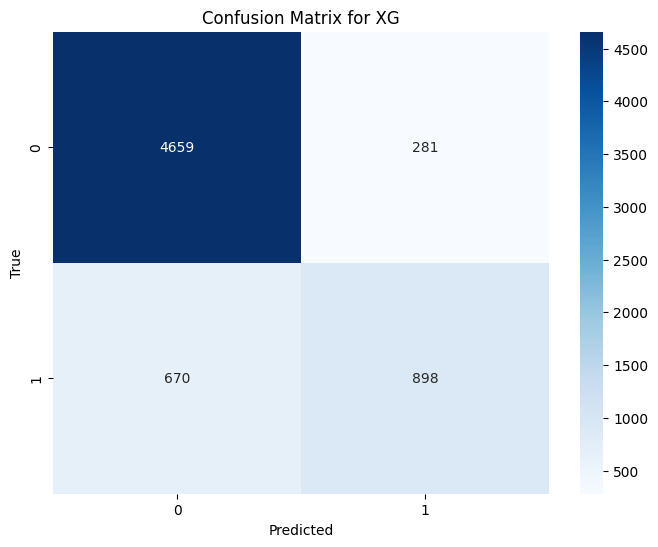

Best Parameters for RF: {'model__criterion': 'gini', 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Best Score for RF: 0.8390260406691017
Train accuracy: 0.8971
Test accuracy: 0.8331
**************************************************
Classification Report for RF:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      4940
           1       0.69      0.60      0.64      1568

    accuracy                           0.84      6508
   macro avg       0.78      0.76      0.77      6508
weighted avg       0.83      0.84      0.83      6508



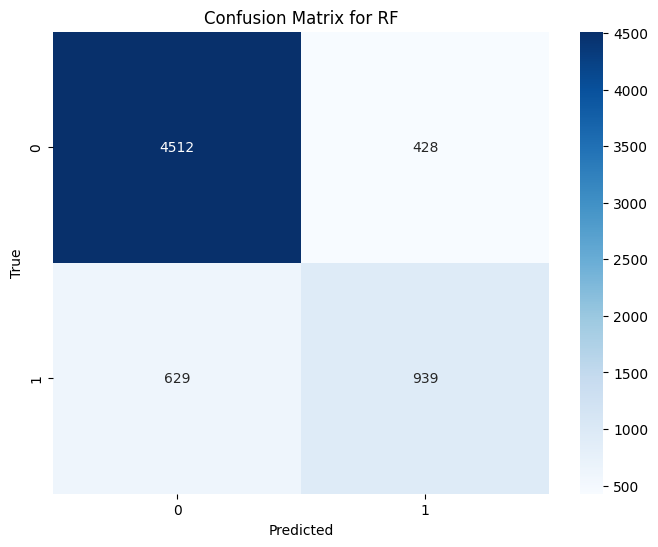

Best Parameters for Voting: {'model__voting': 'hard', 'model__weights': [2, 1, 1]}
Best Score for Voting: 0.8503980074716123
Train accuracy: 0.8768
Test accuracy: 0.8421
**************************************************
Classification Report for Voting:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.57      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



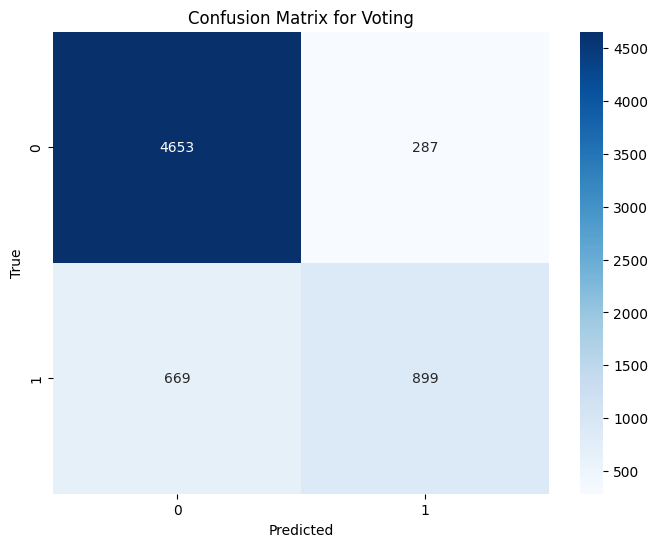

In [42]:
models = {
    "TREE": DecisionTreeClassifier(),
    
    "MNB": MultinomialNB(),
    "GNB": GaussianNB(),
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "XG": XGBClassifier(),
    "RF": RandomForestClassifier(),
    "Voting": VotingClassifier(estimators=[
        ('lr', LogisticRegression()), 
        ('rf', RandomForestClassifier()), 
        ('gnb', GaussianNB())
    ])
}

results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)
    
    # Store the results
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'y_pred': y_pred
    }
    scores = cross_validate(pipeline, X, y, cv=5, scoring="accuracy", return_train_score=True)
    # Print the results
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Score for {model_name}: {grid_search.best_score_}")
    
    print(f"Train accuracy: {scores['train_score'].mean():.4f}")
    print(f"Test accuracy: {scores['test_score'].mean():.4f}")
    print("*" * 50)


    
    
    # Classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

Model: TREE
Train Accuracy: 0.8503
Test Accuracy: 0.8465
Classification Report for TREE:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      4940
           1       0.75      0.54      0.63      1568

    accuracy                           0.85      6508
   macro avg       0.81      0.74      0.77      6508
weighted avg       0.84      0.85      0.84      6508



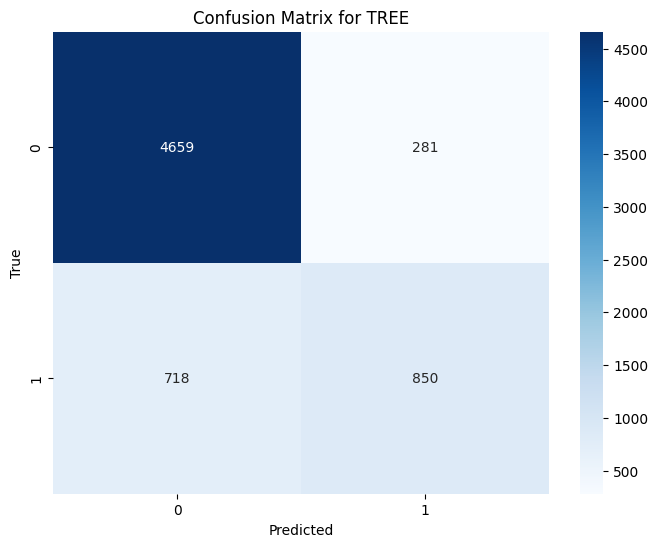

Model: MNB
Train Accuracy: 0.8237
Test Accuracy: 0.8279
Classification Report for MNB:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      4940
           1       0.64      0.65      0.65      1568

    accuracy                           0.83      6508
   macro avg       0.76      0.77      0.77      6508
weighted avg       0.83      0.83      0.83      6508



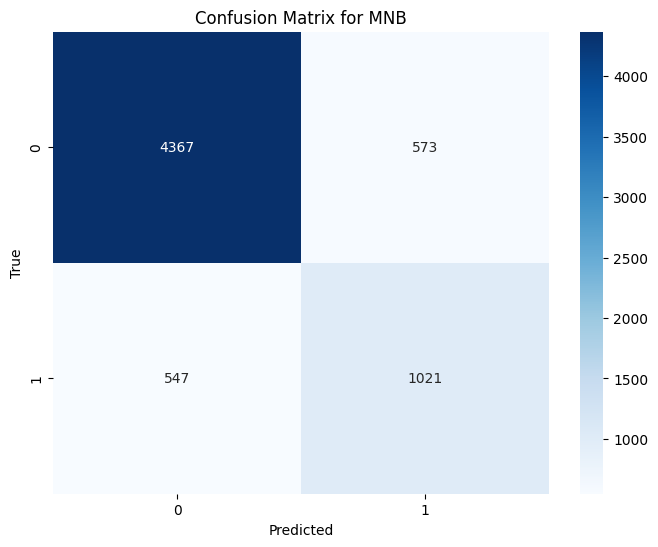

Model: GNB
Train Accuracy: 0.6556
Test Accuracy: 0.6577
Classification Report for GNB:
               precision    recall  f1-score   support

           0       0.96      0.57      0.72      4940
           1       0.41      0.93      0.57      1568

    accuracy                           0.66      6508
   macro avg       0.69      0.75      0.64      6508
weighted avg       0.83      0.66      0.68      6508



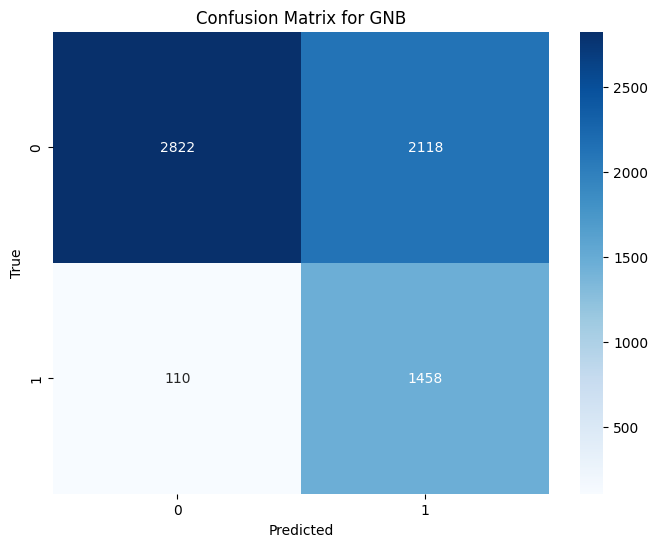

Model: LR
Train Accuracy: 0.8506
Test Accuracy: 0.8530
Classification Report for LR:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.58      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



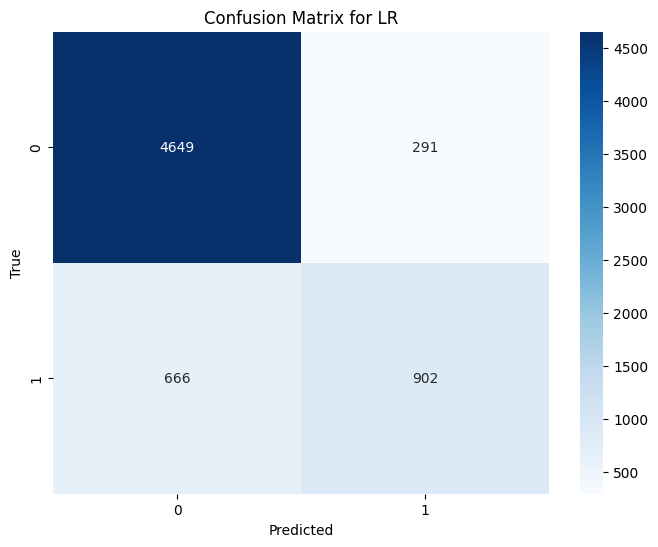

Model: KNN
Train Accuracy: 0.8442
Test Accuracy: 0.8299
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4940
           1       0.68      0.56      0.61      1568

    accuracy                           0.83      6508
   macro avg       0.77      0.74      0.75      6508
weighted avg       0.82      0.83      0.82      6508



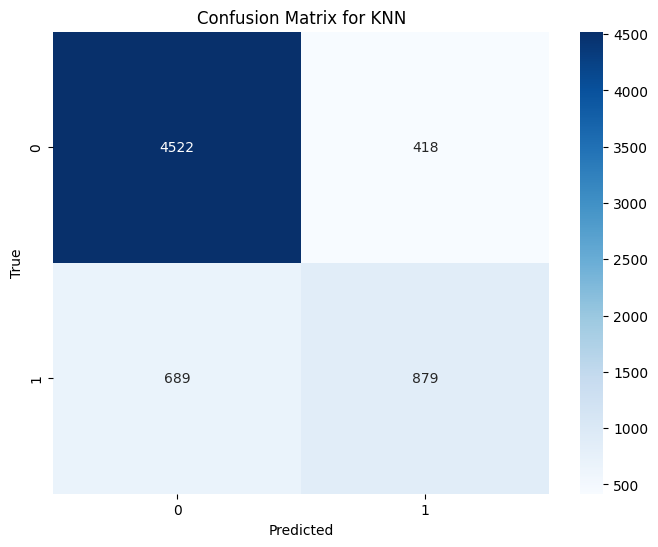

Model: XG
Train Accuracy: 0.8575
Test Accuracy: 0.8539
Classification Report for XG:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.57      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



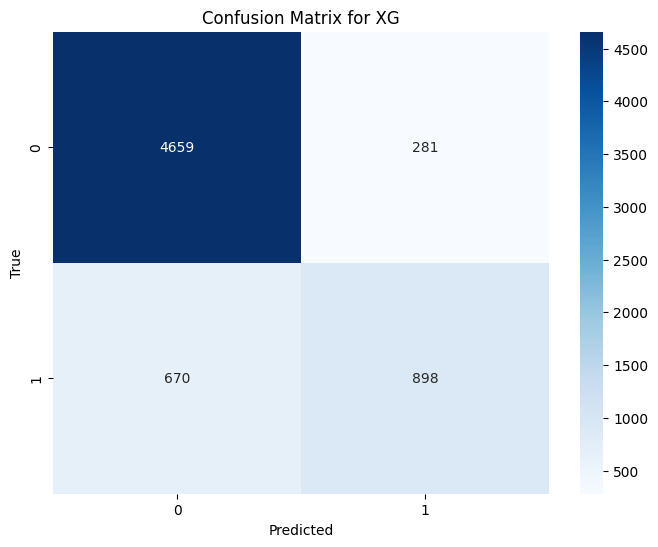

Model: RF
Train Accuracy: 0.8969
Test Accuracy: 0.8370
Classification Report for RF:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      4940
           1       0.69      0.59      0.64      1568

    accuracy                           0.84      6508
   macro avg       0.78      0.75      0.77      6508
weighted avg       0.83      0.84      0.83      6508



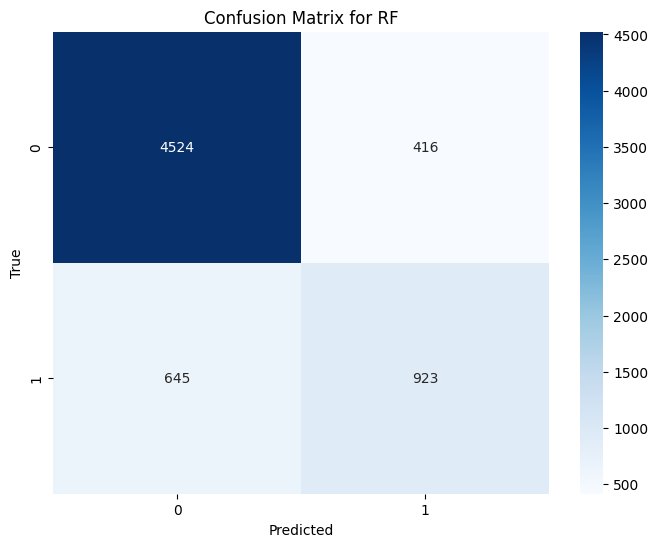

Model: Voting
Train Accuracy: 0.8509
Test Accuracy: 0.8530
Classification Report for Voting:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4940
           1       0.76      0.57      0.65      1568

    accuracy                           0.85      6508
   macro avg       0.82      0.76      0.78      6508
weighted avg       0.85      0.85      0.85      6508



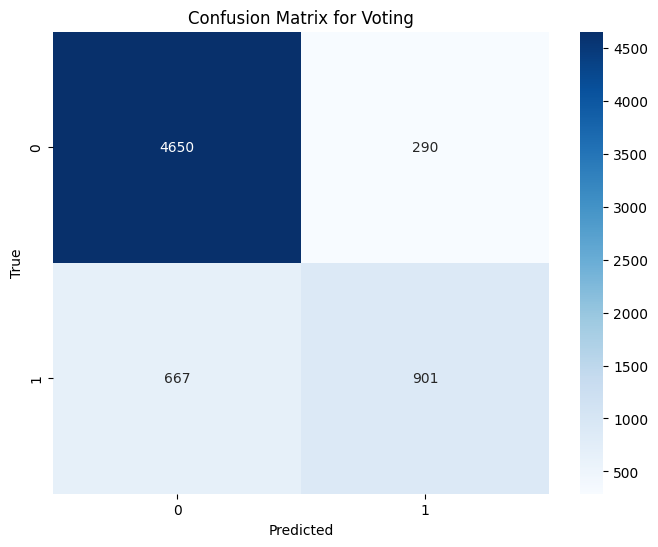

In [43]:


# Define models with best parameters
models = {
    "TREE": DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='best'),
    "MNB": MultinomialNB(alpha=10, fit_prior=True),
    "GNB": GaussianNB(var_smoothing=1e-07),
    "LR": LogisticRegression(C=1, max_iter=100, solver='liblinear'),
    "KNN": KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='uniform'),
    "XG": XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=50),
    "RF": RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=100),
    "Voting": VotingClassifier(estimators=[
        ('lr', LogisticRegression(C=1, max_iter=100, solver='liblinear')),
        ('rf', RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=100)),
        ('gnb', GaussianNB(var_smoothing=1e-07))
    ], voting='hard', weights=[2, 1, 1])
}

# Results dictionary to store results
results = {}

# Loop through models
for model_name, model in models.items():
    # Create pipeline with MinMaxScaler and the model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Apply MinMaxScaler to scale the data
        ('model', model)
    ])
    
    # Fit the model
    pipeline.fit(x_train, y_train)
    
    # Predictions
    y_train_pred = pipeline.predict(x_train)  # Predictions on training set
    y_test_pred = pipeline.predict(x_test)  # Predictions on test set
    
    # Calculate and print accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {model_name}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Store the results
    results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'y_test_pred': y_test_pred
    }
    
    # Print classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_test_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()


In [ ]:
import joblib
joblib.dump(, 'random_forest_model.pkl')